## 今天的範例-常見偵測異常值的方法


### 範例資料
鐵達尼號 train 資料集


In [4]:
# library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn  as sns
from scipy import stats
import math
import statistics
import warnings
warnings.filterwarnings('ignore')
#讓圖可以在 jupyter notebook顯示
%matplotlib inline

In [2]:
df_train = pd.read_csv("Titanic_train.csv")

### 探索性分析:
*  觀察-是否有異常值  
我們來觀察一下 Age 變數吧!!

## Q1:觀察年齡是否有異常值的現象?

mean: 29.69911764705882
std: 14.526497332334042


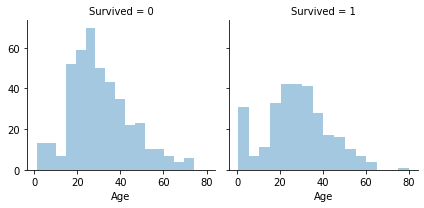

In [5]:
print('mean:', df_train['Age'].mean()) #age平均
print('std:', df_train['Age'].std()) #age標準差
# 連續型用分布圖行來看
g = sns.FacetGrid(df_train, col='Survived')
g.map(sns.distplot, 'Age', kde=False);

---
## 方法1
* 進行一個描述性的統計（規定範圍），從而檢視哪些值是不合理的（範圍以外的值）。  


In [6]:
#先透過 計算統計值， 分別呈現數量，年齡平均，標準差，最大值和最小值。

print(df_train['Age'].describe())

# 透過這樣的方式，年齡最小 0.4 歲和 80 歲都在合理範圍內，所以第一關 pass。

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


---
## 方法 2
* 進行 3 倍標準差原則的計算，從而檢視哪些值是可疑的異常值。  


## Z-score method

In [7]:
#http://colingorrie.github.io/outlier-detection.html
import numpy as np

# 創建一個函數，計算在這個資料中， ys:資料，times : 幾倍標準差，找出在這樣條件下的異常值。
def outliers_z_score(ys, times):
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > times)

out_index = outliers_z_score(df_train['Age'], 3)
print(out_index[0])

print("用第二種方法找出的 outlier 有哪些?")
print(df_train.loc[out_index[0],'Age'])
#  所以用這個方法，找出的 outlier 就是少數族群，年齡較大的，一位是 80 和 74。

[630 851]
用第二種方法找出的 outlier 有哪些?
630    80.0
851    74.0
Name: Age, dtype: float64


---
## 異常值的判別方法 3 - 盒鬚圖判別法 (IQR method)

In [8]:
import numpy as np
# 透過一個函數來判斷是否為異常值
def outliers_iqr(ys, times):
    # 注意: 使用 np.percentile 要去除 nan 要不然計算出來會錯誤，所以我們採用下者的程式 np.nanpercentile
    # quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    quartile_1, quartile_3 = np.nanpercentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * times)
    upper_bound = quartile_3 + (iqr * times)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [10]:
out_index2 = outliers_iqr(df_train['Age'], 1.5)
print(out_index2[0])
print("用第三種方法找出的 outlier 有哪些? (1.5 倍IQR)")
print(df_train.loc[out_index2[0], 'Age'])

[ 33  54  96 116 280 456 493 630 672 745 851]
用第三種方法找出的 outlier 有哪些? (1.5 倍IQR)
33     66.0
54     65.0
96     71.0
116    70.5
280    65.0
456    65.0
493    71.0
630    80.0
672    70.0
745    70.0
851    74.0
Name: Age, dtype: float64


In [11]:
out_index3 = outliers_iqr(df_train['Age'], 2)
print(out_index3[0])
print("用第三種方法找出的 outlier 有哪些? (2 倍IQR)")
print(df_train.loc[out_index3[0], 'Age'])

[630 851]
用第三種方法找出的 outlier 有哪些? (2 倍IQR)
630    80.0
851    74.0
Name: Age, dtype: float64


---
## 畫盒鬚圖
方法：利用 matplotlib 包中 axes 物件的 `boxplot()`方法。

透過 whis 來設定 IQR 的倍數
```
whis : float or (float, float), default: 1.5
       The position of the whiskers.
```

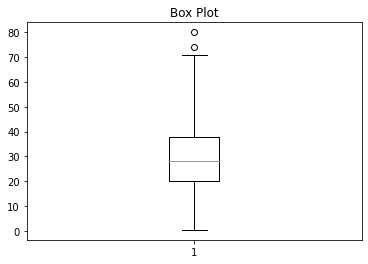

In [16]:
# 使用 np.isnan(data)，找出在 age 中的遺失值
# 然後逐位反轉，讓遺失值為 0, 則可以透過索引的方式，濾掉遺失值

plt.boxplot(df_train['Age'][~np.isnan(df_train['Age'])], whis=2)    #作圖
plt.title('Box Plot')
plt.show()

## 但在用任何方法後，都需要做判斷，這是 outlier 嗎?
* 需有業務面的資訊可以輔助你回答這問題，   
在鐵達尼案例中，年紀的似乎沒有 outlier，
但有時候 outlier 判斷無法從單一變數檢視出來，
假如 80.0 的這個人，但是在姓名中，發現她可能是個小孩，那 80 歲的年紀，就有可能是 outlier。